In [ ]:
# customed function 생성
#### alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성했습니다.
# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [1]:
import sys
import sktime
import tqdm as tq
import xgboost as xgb
import matplotlib
import seaborn as sns
import sklearn 
import pandas as pd
import numpy as np
import scipy
print("-------------------------- library version --------------------------")
print(f"Python version: ",{sys.version})
print(f"pandas version: ",{pd.__version__})
print(f"numpy version: ",{np.__version__})
print(f"matplotlib version: ",{matplotlib.__version__})
print(f"tqdm version: ",{tq.__version__})
print(f"sktime version: ",{sktime.__version__})
print(f"xgboost version: ",{xgb.__version__})
print(f"seaborn version: ",{sns.__version__})
print(f"scikit-learn version: ",{sklearn.__version__})
print(f"scipy.stats version",{scipy.__version__})
print("---------------------------------------------------------------------")

-------------------------- library version --------------------------
Python version:  {'3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]'}
pandas version:  {'2.0.3'}
numpy version:  {'1.24.3'}
matplotlib version:  {'3.7.2'}
tqdm version:  {'4.64.0'}
sktime version:  {'0.13.2'}
xgboost version:  {'1.6.2'}
seaborn version:  {'0.12.2'}
scikit-learn version:  {'1.0.2'}
scipy.stats version {'1.9.3'}
------------------------------------------------------------------------------


In [ ]:
# 강수량일 계절마다 바뀌는 특성이 있음
# 강수량이 결측값으로 채워진 것에 대한 처리 방법으로 보간법, K-NN알고리즘을 사용
# 보간법(interpolation)에는 선형, 스플라인 보간법이 존재한다  from scipy import interpolate
# K-NN 알고리즘을 사용한 결측값 처리에는 from sklearn.impute import KNNImputer

# 이번 경우에는 fillna로 비슷한 계절 특성을 이용하여 결측값을 채워 넣는 방법 사용

In [4]:
from scipy import interpolate
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer

from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

from sklearn.model_selection import train_test_split

In [2]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')
building_df=pd.read_csv('building_info.csv')
sample=pd.read_csv('sample_submission.csv')

In [3]:
train_df=pd.merge(train_df,building_df,on='건물번호',how='left')
test_df=pd.merge(test_df,building_df,on='건물번호',how='left')

train_df.drop(['태양광용량(kW)','ESS저장용량(kWh)', 'PCS용량(kW)','건물유형'],axis=1,inplace=True)
test_df.drop(['태양광용량(kW)','ESS저장용량(kWh)', 'PCS용량(kW)','건물유형'],axis=1,inplace=True)

In [5]:
train_df

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),연면적(m2),냉방면적(m2)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28,110634.00,39570.00
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36,110634.00,39570.00
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88,110634.00,39570.00
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76,110634.00,39570.00
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40,110634.00,39570.00
...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04,57497.84,40035.23
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96,57497.84,40035.23
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12,57497.84,40035.23
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08,57497.84,40035.23


In [6]:
train_df.drop(['일조(hr)','일사(MJ/m2)'],axis=1,inplace=True)

In [7]:

train_df['풍속(m/s)']=train_df['풍속(m/s)'].fillna(round(train_df['풍속(m/s)'].mean(),2))
train_df['습도(%)']=train_df['습도(%)'].fillna(round(train_df['습도(%)'].mean(),2))

# 새로 추가할 변수 생성 
# 1. 불쾌지수(THI)

train_df['THI']=round(1.8*train_df['기온(C)'] - 0.55*(1-train_df['습도(%)']/100) * (1.8*train_df['기온(C)'] - 26) + 32)
test_df['THI']=round(1.8*test_df['기온(C)'] - 0.55*(1-test_df['습도(%)']/100) * (1.8*test_df['기온(C)'] - 26) + 32)

# train_df['THI']=pd.cut(train_df['THI'],bins=[30,60,75,85,100], labels=[1,2,3,4])
# test_df['THI']=pd.cut(test_df['THI'],bins=[30,60,75,85,100], labels=[1,2,3,4]) # 불쾌지수를 범주화

In [10]:
train_df=train_df.rename(columns={
    'num_date_time':'date',
    '건물번호':'build_number',
    '일시':'date_time',
    '기온(C)':'temp',
    '강수량(mm)' : 'rain',
    '풍속(m/s)': 'wind',
    '습도(%)': 'humid',
    '전력소비량(kWh)':'power_consum',  ##
    '연면적(m2)':'area',
    '냉방면적(m2)':'cool_area',
    'THI':'THI'
})

In [9]:
test_df=test_df.rename(columns={
    'num_date_time':'date',
    '건물번호':'build_number',
    '일시':'date_time',
    '기온(C)':'temp',
    '강수량(mm)' : 'rain',
    '풍속(m/s)': 'wind',
    '습도(%)': 'humid',
    '연면적(m2)':'area',
    '냉방면적(m2)':'cool_area',
    'THI':'THI'
})

In [11]:
train_df['THI_change']=train_df['THI'].pct_change()
test_df['THI_change']=test_df['THI'].pct_change()

train_df['THI_change']=train_df['THI_change'].fillna(0.0)
test_df['THI_change']=test_df['THI_change'].fillna(0.0)

# 불쾌지수 변화율

In [12]:
train_df

,date,build_number,date_time,temp,rain,wind,humid,power_consum,area,cool_area,THI,THI_change
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,1085.28,110634.00,39570.00,63.0,0.000000
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,1047.36,110634.00,39570.00,62.0,-0.015873
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,974.88,110634.00,39570.00,62.0,0.000000
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,953.76,110634.00,39570.00,61.0,-0.016129
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,986.40,110634.00,39570.00,63.0,0.032787
...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,881.04,57497.84,40035.23,72.0,-0.027027
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,798.96,57497.84,40035.23,71.0,-0.013889
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,825.12,57497.84,40035.23,70.0,-0.014085
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,640.08,57497.84,40035.23,69.0,-0.014286


In [11]:
def resumtable(df):
    print( f'데이터 형상: ',{df.shape})
    summary=pd.DataFrame(df.dtypes,columns=['데이터 타입'])
    summary=summary.reset_index()
    summary=summary.rename(columns={'index':'feature'})
    summary['결측값 개수']=df.isnull().sum().values
    summary['고유값 개수']=df.nunique().values
    summary['첫 번째 값']=df.loc[0].values
    summary['두 번째 값']=df.loc[1].values
    summary['세 번째 값']=df.loc[2].values

    return summary

In [ ]:
# 종속변수 분리

# elec_power=train_df['전력소비량(kWh)']
# train_df=train_df.drop(['전력소비량(kWh)'],axis=1)

In [13]:
# (num_date_time, 일시) column 제거하기 위해 month / day / time(시간)으로 전처리

train_df['month']=train_df['date_time'].apply(lambda x:int(x[4:6]))
train_df['day']=train_df['date_time'].apply(lambda x:int(x[6:8]))
train_df['time']=train_df['date_time'].apply(lambda x:int(x[9:11]))

test_df['month']=test_df['date_time'].apply(lambda x:int(x[4:6]))
test_df['day']=test_df['date_time'].apply(lambda x:int(x[6:8]))
test_df['time']=test_df['date_time'].apply(lambda x:int(x[9:11]))

train_df=train_df.drop(['date','date_time'],axis=1)
test_df=test_df.drop(['date','date_time'],axis=1)

In [ ]:
# new_table=pd.pivot_table(train_df, index='build_number', columns=['day'], values=['전력소비량(kWh)'],aggfunc='mean')

In [14]:
train_df

,build_number,temp,rain,wind,humid,power_consum,area,cool_area,THI,THI_change,month,day,time
0,1,18.6,NaN,0.9,42.0,1085.28,110634.00,39570.00,63.0,0.000000,6,1,0
1,1,18.0,NaN,1.1,45.0,1047.36,110634.00,39570.00,62.0,-0.015873,6,1,1
2,1,17.7,NaN,1.5,45.0,974.88,110634.00,39570.00,62.0,0.000000,6,1,2
3,1,16.7,NaN,1.4,48.0,953.76,110634.00,39570.00,61.0,-0.016129,6,1,3
4,1,18.4,NaN,2.8,43.0,986.40,110634.00,39570.00,63.0,0.032787,6,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,NaN,0.9,86.0,881.04,57497.84,40035.23,72.0,-0.027027,8,24,19
203996,100,22.4,NaN,1.3,86.0,798.96,57497.84,40035.23,71.0,-0.013889,8,24,20
203997,100,21.3,NaN,1.0,92.0,825.12,57497.84,40035.23,70.0,-0.014085,8,24,21
203998,100,21.0,NaN,0.3,94.0,640.08,57497.84,40035.23,69.0,-0.014286,8,24,22


In [14]:
train_df=train_df[train_df.columns[6:].to_list()+train_df.columns[0:6].to_list()]
test_df=test_df[test_df.columns[5:].to_list()+test_df.columns[0:5].to_list()]

In [ ]:
train_df

0    1008.0
Name: power_consum, dtype: float64
1766.4
2451.036461952613


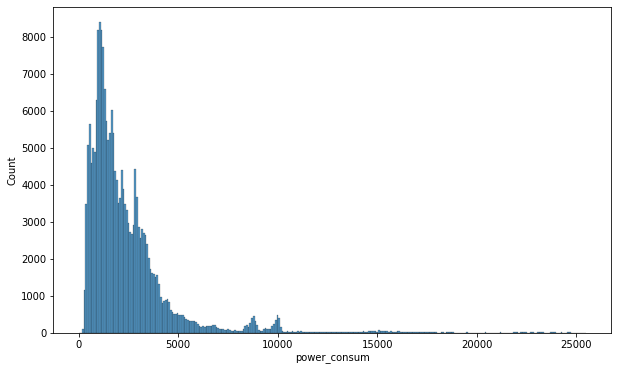

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.histplot(train_df, x='power_consum',bins=300)


# 종속변수에서는 오른쪽으로 꼬리가 긴 pos_skew를 보여주고 있음   -> 꼬리 부분에 있는 데이터를 scale해야한다는 뜻
# 이럴 땐 log / root / 역수 변환을 사용할 수 있다 

# 반대로 neg_skew의 경우는 지수/ 제곱을 변환으로 사용할 수 있음

# 로그노말분포 -> 금융공학, 통계등에서 사용하는 용어로써 로그변환을 했을 때 정규분포가 되는 분포를 가리킴
# (아래 보이는 전력 사용량 분포를 log-normal distibutuion이라고 할 수 있음)

print(train_df['power_consum'].mode())
print(train_df['power_consum'].median())
print(train_df['power_consum'].mean())
# 최빈값 < 중앙값 < 평균  -> pos_skewed의 특성

((array([-4.49999366, -4.30771372, -4.20335321, ...,  4.20335321,
          4.30771372,  4.49999366]),
  array([ 0.        ,  0.3074847 ,  4.97466263, ..., 10.14073123,
         10.14315778, 10.14601796])),
 (0.7509617836099143, 7.500518485122759, 0.9963719160536602))

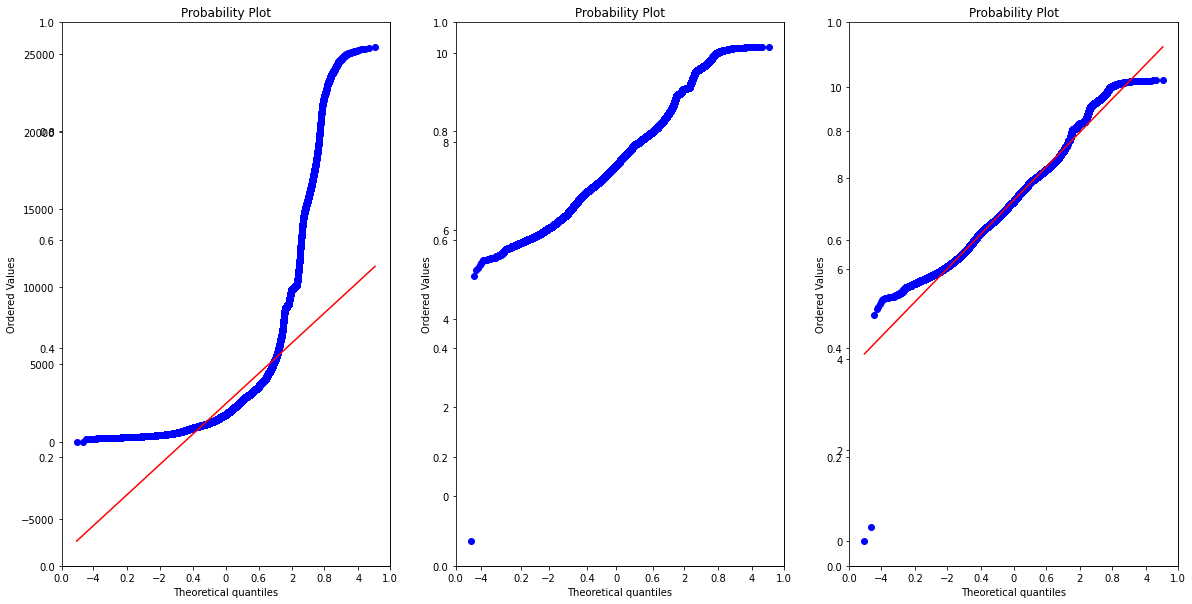

In [20]:
fig ,ax= plt.subplots(1,3,figsize=(20,10))

fig.add_subplot(1,3,1)
scipy.stats.probplot(train_df['power_consum'], plot=plt)

fig.add_subplot(1,3,2)
scipy.stats.probplot(np.log(train_df['power_consum']), plot=plt)

fig.add_subplot(1,3,3)
scipy.stats.probplot(np.log1p(train_df['power_consum']), plot=plt)


# np.log(data + 1)의 변환을 해준 결과 이전보다는 정규분포를 보여줌
# np.log1p()는 데이터가 0일 때 -inf인 문제를 해결해주기 위해 사용

# 아래 그래프에서도 확인 가능 

In [21]:
# train_df 에서 강수량에 결측치가 전체 비율의 50%를 넘게 차지하기 때문에 제거
train_df['rain']=train_df['rain'].fillna(0.0)

# test_df에서도 같이 제거
# test_df=test_df.drop('강수량(mm)',axis=1)

In [23]:
train_df

,area,cool_area,THI,THI_change,month,day,time,build_number,temp,rain,wind,humid,power_consum
0,110634.00,39570.00,63.0,0.000000,6,1,0,1,18.6,0.0,0.9,42.0,1085.28
1,110634.00,39570.00,62.0,-0.015873,6,1,1,1,18.0,0.0,1.1,45.0,1047.36
2,110634.00,39570.00,62.0,0.000000,6,1,2,1,17.7,0.0,1.5,45.0,974.88
3,110634.00,39570.00,61.0,-0.016129,6,1,3,1,16.7,0.0,1.4,48.0,953.76
4,110634.00,39570.00,63.0,0.032787,6,1,4,1,18.4,0.0,2.8,43.0,986.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,57497.84,40035.23,72.0,-0.027027,8,24,19,100,23.1,0.0,0.9,86.0,881.04
203996,57497.84,40035.23,71.0,-0.013889,8,24,20,100,22.4,0.0,1.3,86.0,798.96
203997,57497.84,40035.23,70.0,-0.014085,8,24,21,100,21.3,0.0,1.0,92.0,825.12
203998,57497.84,40035.23,69.0,-0.014286,8,24,22,100,21.0,0.0,0.3,94.0,640.08


In [24]:
train_df.drop('area',axis=1,inplace=True)
test_df.drop('area',axis=1,inplace=True)

In [25]:
train_df

,cool_area,THI,THI_change,month,day,time,build_number,temp,rain,wind,humid,power_consum
0,39570.00,63.0,0.000000,6,1,0,1,18.6,0.0,0.9,42.0,1085.28
1,39570.00,62.0,-0.015873,6,1,1,1,18.0,0.0,1.1,45.0,1047.36
2,39570.00,62.0,0.000000,6,1,2,1,17.7,0.0,1.5,45.0,974.88
3,39570.00,61.0,-0.016129,6,1,3,1,16.7,0.0,1.4,48.0,953.76
4,39570.00,63.0,0.032787,6,1,4,1,18.4,0.0,2.8,43.0,986.40
...,...,...,...,...,...,...,...,...,...,...,...,...
203995,40035.23,72.0,-0.027027,8,24,19,100,23.1,0.0,0.9,86.0,881.04
203996,40035.23,71.0,-0.013889,8,24,20,100,22.4,0.0,1.3,86.0,798.96
203997,40035.23,70.0,-0.014085,8,24,21,100,21.3,0.0,1.0,92.0,825.12
203998,40035.23,69.0,-0.014286,8,24,22,100,21.0,0.0,0.3,94.0,640.08


In [26]:
test_df['humid']=test_df['humid'].astype('float64')

In [27]:
train_df=train_df.drop('build_number',axis=1)
test_df.drop('build_number',axis=1,inplace=True)

In [28]:
train_df

,cool_area,THI,THI_change,month,day,time,temp,rain,wind,humid,power_consum
0,39570.00,63.0,0.000000,6,1,0,18.6,0.0,0.9,42.0,1085.28
1,39570.00,62.0,-0.015873,6,1,1,18.0,0.0,1.1,45.0,1047.36
2,39570.00,62.0,0.000000,6,1,2,17.7,0.0,1.5,45.0,974.88
3,39570.00,61.0,-0.016129,6,1,3,16.7,0.0,1.4,48.0,953.76
4,39570.00,63.0,0.032787,6,1,4,18.4,0.0,2.8,43.0,986.40
...,...,...,...,...,...,...,...,...,...,...,...
203995,40035.23,72.0,-0.027027,8,24,19,23.1,0.0,0.9,86.0,881.04
203996,40035.23,71.0,-0.013889,8,24,20,22.4,0.0,1.3,86.0,798.96
203997,40035.23,70.0,-0.014085,8,24,21,21.3,0.0,1.0,92.0,825.12
203998,40035.23,69.0,-0.014286,8,24,22,21.0,0.0,0.3,94.0,640.08


In [29]:
train_df['power_consum']=np.log1p(train_df['power_consum'])  
# 추후에 지수변환 다시 해야함 (예측 다 하고 마지막에 지수변환)

# 다시 지수변환 할 때는 np.expm1()

In [30]:
elec_power=train_df['power_consum']
train_df.drop('power_consum',axis=1,inplace=True)

In [61]:
cols=train_df.columns[[0,1,2,6,7,8,9]]

In [62]:
cols

Index(['cool_area', 'THI', 'THI_change', 'temp', 'rain', 'wind', 'humid'], dtype='object')

In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
train_data = scaler.fit_transform(train_df.drop(['month','day','time'],axis=1).values)

In [37]:
test_data = scaler.transform(test_df.drop(['month','day','time'],axis=1).values)

In [49]:
new_tr=pd.DataFrame(train_data, columns=[cols])
new_test=pd.DataFrame(test_data, columns=[cols])

In [51]:
tr_df=pd.concat([new_tr, train_df[['month','day','time']]],axis=1)
tt_df=pd.concat([new_test, test_df[['month','day','time']]],axis=1)

In [58]:
tr_df

,"(cool_area,)","(THI,)","(THI_change,)","(temp,)","(rain,)","(wind,)","(humid,)",month,day,time
0,0.003616,0.309524,0.657568,0.314815,0.0,0.067669,0.333333,6,1,0
1,0.003616,0.285714,0.609555,0.292593,0.0,0.082707,0.367816,6,1,1
2,0.003616,0.285714,0.657568,0.281481,0.0,0.112782,0.367816,6,1,2
3,0.003616,0.261905,0.608781,0.244444,0.0,0.105263,0.402299,6,1,3
4,0.003616,0.309524,0.756742,0.307407,0.0,0.210526,0.344828,6,1,4
...,...,...,...,...,...,...,...,...,...,...
203995,0.003659,0.523810,0.575817,0.481481,0.0,0.067669,0.839080,8,24,19
203996,0.003659,0.500000,0.615557,0.455556,0.0,0.097744,0.839080,8,24,20
203997,0.003659,0.476190,0.614965,0.414815,0.0,0.075188,0.908046,8,24,21
203998,0.003659,0.452381,0.614357,0.403704,0.0,0.022556,0.931034,8,24,22


In [ ]:
x_tr,x_val,y_tr,y_val=train_test_split(tr_df,elec_power,test_size=0.3, random_state=43)

x_tr.shape,y_tr.shape,x_val.shape,y_val.shape

## XGBoost

### 장점

#### 1. 뛰어난 예측성능
#### 2. gbm보다 빠른 수행 속도 
#### 3. tree pruning -> 이득이 없는 분할을 가지치기
#### 4. 자체 내장된 교차검증  ->즉 조기 중단도 가능
#### 5. 결측값 자체 처리

### XGBoost + random 파라미터 탐색

In [ ]:
model=xgb.XGBRegressor(random_state=43)

# model.get_params()


params={
     'n_estimators':[10000],
     'max_depth': [7,8],
     'learning_rate': [0.1,0.05,0.001],
     'min_child_weight': [14,15,16],  # 분할 할 때 가중치 합을 기준으로 결정하는 파라미터 (즉, 과적합 제어 가능)
     'colsample_bytree':[0.7,1]
} 
# 다른 파라미터들

# sub_sample -> 샘플링에 사용할 데이터의 크기 (0.5~1)
# colsample_bytree  -> 컬럼의 비율 랜포에서 featrue_freaction이랑 같은 효과
# scale_pos_weight  -> 불균형한 클래스 데이터의 분포를 조정

random_xgb_model=RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=20,  # 파라미터 검색 횟수
                                   scoring='neg_mean_absolute_error', # 지정해주지 않으면 기본적으로 분류: accuracy, 회귀 R^2
                                                                      # scoring 지정해주는 게 좋음
                                   cv=3)  # cv가 3이면 첫 fold를 검증용, 다음은 두 번째 fold 검증용 .... 해서 모든 fold를 사용하고
                                          # 결과를 평균 

random_xgb_model.fit(x_tr,y_tr, 
                     eval_set=[(x_tr, y_tr), (x_val, y_val)],
                     eval_metric='rmse',
                     early_stopping_rounds=30,
                     verbose=False)

print(f'최적의 파라미터',random_xgb_model.best_params_)
print(f'최고 점수',round(random_xgb_model.best_score_,3))



# xgboost 전용 데이터셋  -> DMatirx  (train() 즉, 파이썬 래퍼를 사용할 때 사용 //  사이킷런 래퍼의 fit()과 같은 내용)

## train_dmatrix=xgb.DMatrix(data = x_tr,label = y_tr)
## test_dmatrix=xgb.DMatrix(data = x_val, label = y_val)

### xgboost (파이썬 래퍼 사용 - DMatrix) + bayesian_optimization(파라미터 최적화)

In [ ]:
bayes_tr=xgb.DMatrix(data=x_tr, label=y_tr)
bayes_val=xgb.DMatrix(data=x_val, label=y_val )
bayes_test=xgb.DMatrix(data=test_df)

In [ ]:
params_bounds={  # 가변 param
    'max_depth':(7,11),
    'colsample_bytree':(0.6,1),
    'subsample':(0.6,1),
    'min_child_weight': (10,15),
    'learning_rate':(0.01,0.1)
    
}

fixed_params={   # 고정 param
    'random_state':43,
    'objective':'reg:squarederror',
}

In [ ]:
# def c_rmse(y_pred, Dmatrix):
#     labels = Dmatrix.get_label()
#     return ('custom_rmse', np.sqrt(np.mean(np.power(labels- y_pred, 2))))

In [ ]:
def SMAPE(y_pred, DMatrix):
    labels = DMatrix.get_label()
    smp = (abs(labels - y_pred) / (abs(labels) + abs(y_pred))/ 2) * 100
    smape=smp.mean()
    
    return smape

In [ ]:
# def c_rmse2(Dmatrix, y_preds):
#     y = Dmatrix.get_label()
#     rmse=mean_squared_error(y - y_preds)**2
#     return rmse

In [ ]:
def eval_function(max_depth,subsample,colsample_bytree, min_child_weight,learning_rate):  # 범위가 있는 param만 전달
    params={
        'max_depth':int(round(max_depth)),
        'subsample':subsample,
        'colsample_bytree':colsample_bytree,
        'min_child_weight':min_child_weight,
        'learning_rate':learning_rate
    }
    
    params.update(fixed_params) # 값 고정된 파라미터 추가
    
    print(f'파라미터',params)
    
    xgb_model=xgb.train(params=params,
                       dtrain=bayes_tr,
                       num_boost_round=12000, # 사이킷런 래퍼의 n_estimators와 같은 역할 부스팅 개수 
                       maximize=False,
                       early_stopping_rounds=200,
                       evals=[(bayes_val,'bayes_val')],
                       feval=SMAPE  # feval에 내가 선언한 함수 적용
               )
    
    best_iter=xgb_model.best_iteration # 최적 반복횟수
    
    preds=xgb_model.predict(bayes_val,iteration_range=(0,best_iter))
    
    smape_score=SMAPE(preds, bayes_val)
    print(f'smape: ', smape_score)
    
    return smape

In [ ]:
from bayes_opt import BayesianOptimization


optimizer = BayesianOptimization(f=eval_function,  # 선언한 함수 적용
                                pbounds = params_bounds,
                                random_state=43)


optimizer.maximize(init_points=6, # 수행할 무작위 탐색 단계
                  n_iter=10) # 수행하려는 베이지안 최적화 단계, 더 많은 단계를 거치면 더 좋은 결과를 얻음
                    # init_points 큰 값 설정, 전체 구간에 대한 충분한 사전 탐색을 수행해 놓을 수 있으나 시간이 많이 소요


### (1)

파라미터 {max_depth': 9, 'subsample': 0.6962358479861395, 'colsample_bytree': 0.6460218265559116, 'min_child_weight': 9.666954820929941, 'random_state': 43, 'objective': 'reg:squarederror', 'learning_rate': 0.0005}

In [ ]:
xgb_model1=xgb.XGBRegressor(n_estimators=10000,
                          max_depth= 9, subsample = 0.6962358479861395, colsample_bytree = 0.6460218265559116, 
                          min_child_weight = 9.666954820929941, random_state =43, 
                          learning_rate = 0.05)


xgb_model1.fit(x_tr,y_tr)

# 최적 파라미터 적용

In [1]:
preds=xgb_model1.predict(test_df)
last_preds=np.exp(preds)

sample['answer']=last_preds
sample.to_csv('elec_power_9.csv',index=False)

### (2)

파라미터 {'max_depth': 8, 'subsample': 0.7308556223244559, 'colsample_bytree': 0.6460218265559116, 
      'min_child_weight': 11.202948099826743, 'learning_rate': 0.06481598853515333, 
      'random_state': 43,   'objective': 'reg:squarederror'}

In [ ]:
xgb_model_bayes2=xgb.XGBRegressor(n_estimators=10000 , max_depth=8, subsample= 0.7308556223244559, colsample_bytree= 0.6460218265559116, 
                                  min_child_weight= 11.202948099826743, learning_rate= 0.06481598853515333, 
                                  random_state= 43)



xgb_model_bayes2.fit(x_tr,y_tr)


In [ ]:
preds=xgb_model_bayes2.predict(test_df)
test_power_consum=np.expm1(preds)
sample['answer']=test_power_consum
sample.to_csv('elec_power_11.csv',index=False)

In [ ]:
# model.fit(x_tr,y_tr. eval_set=[(),()],
#          eval_metirc='~~~',
#          early_stopping_rounds=,
#          objective='reg:squarederror'. # 회귀 (디폴트)
#          objective='binary:logistict', # 이진 분류: 클래스 반환
#          objective='multi:softmax', # 다중 분류, 클래스 반환
#          objective='multi:softprob', # 다중 분류, 확률 반환)

### (3)
중요 파라미터 최적값 {'n_estimators': 4000, 'min_child_weight': 12, 'max_depth': 7, 'learning_rate': 0.05}   

###   최고 성능 -0.053